In [2]:


from abc import ABC, abstractmethod
# import all the necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay, ExponentialDecay, CosineDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from sklearn.metrics import roc_curve, auc
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/local/d1/smartpixML/filtering_models/shuffling_data/") #TODO use the ODG from here
##import OptimizedDataGenerator4_data_shuffled_bigData as ODG2
import pandas as pd
from datetime import datetime


sys.path.append(str(Path.cwd().parents[0]))

from MuC_Smartpix_ML.Model_Classes import SmartPixModel
print(SmartPixModel)

<class 'MuC_Smartpix_ML.Model_Classes.SmartPixModel'>


In [3]:
"""
from OptimizedDataGenerator4 import *
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras_tuner as kt
noGPU=False
if noGPU:
    tf.config.set_visible_devices([], 'GPU')

print("\nHIIIIIIIIIIIIIIIIII\n")

print(tf.config.experimental.list_physical_devices())
print(tf.test.is_built_with_cuda())
print(tf.test.is_built_with_gpu_support())
print(tf.test.is_gpu_available())
"""

from abc import ABC, abstractmethod
# import all the necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay, ExponentialDecay, CosineDecay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt
from sklearn.metrics import roc_curve, auc
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("/local/d1/smartpixML/filtering_models/shuffling_data/") #TODO use the ODG from here
import OptimizedDataGenerator4_data_shuffled_bigData as ODG2
import pandas as pd
from datetime import datetime



sys.path.append(str(Path.cwd().parents[0]))

from MuC_Smartpix_ML.Model_Classes import SmartPixModel
print(SmartPixModel)

class Model1(SmartPixModel):
    def __init__(self,
            tfRecordFolder: str = "/local/d1/smartpixML/filtering_models/shuffling_data/all_batches_shuffled_bigData_try2/filtering_records16384_data_shuffled_single_bigData/",
            nBits: list = None, # just for fractional bits, integer bits
                                ## number of bits is the number of bits for each quantized model and then
                                ## run training should make one model for each bit size
            loadModel: bool = False,
            modelPath: str = None, # Only include if you are loading a model
                        # dropout_rate: float = 0.1,
            initial_lr: float = 1e-3,
            end_lr: float = 1e-4,
            power: int = 2,
            bit_configs = [(16, 0), (8, 0), (6, 0), (4, 0), (3, 0), (2, 0)]  # Test 16, 8, 6, 4, 3, and 2-bit quantization
            ): 
        self.tfRecordFolder = tfRecordFolder
        self.modelName = "Model1" # for other models, e.g., Model 1, Model 2, etc.
        # self.model = None
        self.histories = {}
        self.models = {"Unquantized": None}
        self.bit_configs = bit_configs
        for total_bits, int_bits in self.bit_configs:
            config_name = f"quantized_{total_bits}w{int_bits}i"
            self.models[config_name] = None
        # self.quantized_model = None
        self.hyperparameterModel = None
        self.training_generator = None
        self.validation_generator = None
        self.x_feature_description: list = ['z_global','x_size', 'y_size', 'y_local']
        # Learning rate parameters
        self.initial_lr = initial_lr
        self.end_lr = end_lr
        self.power = power
        return
     
    def makeUnquantizedModel(self):
        ## here i will be making a 4-layer neural network 
        ## Model 1: z-global, x size, y size, y local


        ## define the inputs
        input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
        input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
        input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
        input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

        ## concatenate the inputs into one layer
        inputList = [input1, input2, input3, input4]
        inputs = tf.keras.layers.Concatenate()(inputList)


        ## here i will add the layers 

        stack1 = tf.keras.layers.Dense(2,activation='relu')(inputs)
        stack2 = tf.keras.layers.Dense(2,activation='relu')(stack1)
        output = tf.keras.layers.Dense(1,activation='sigmoid')(stack2)

        self.models["Unquantized"] = tf.keras.Model(inputs=inputList, outputs=output)


    def makeUnquatizedModelHyperParameterTuning(self):
        def model_builder(hp):
            # ── B) Architecture hyperparams ──────────────────────────────────────────
            # separately tune rows and cols

            row1nodes      = hp.Int("1",   1, 30, step=1)
            row2nodes      = hp.Int("2",   1, 30, step=1)
            row3nodes      = hp.Int("3",   1, 30, step=1)
            row4nodes      = hp.Int("4",   1, 30, step=1)
            row5nodes      = hp.Int("5",   1, 30, step=1)



            input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
            input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
            input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
            input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

            ## concatenate the inputs into one layer
            inputList = [input1, input2, input3, input4]
            inputs = tf.keras.layers.Concatenate()(inputList)


            ## here i will add the layers 

            # layer 1
            x = tf.keras.layers.Dense(row1nodes,activation='relu')(inputs)
            x = tf.keras.layers.Dense(row5nodes, activation='relu')(x)
            output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

            model = tf.keras.Model(inputs=inputList, outputs=output)

            model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=["binary_accuracy"],
            run_eagerly  = True 
            )
            return model

        tuner = kt.RandomSearch(
        model_builder, 
        objective           = "val_binary_accuracy",
        max_trials          = 120,
        executions_per_trial = 2,
        project_name        = "hp_search_1_30"
        )

        tuner.search(
            self.training_generator,
            validation_data = self.validation_generator,
            epochs          = 110,
            callbacks       = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            ]
        )


    def makeUnquatizedModelHyperParameterTuning5(self):
        def model_builder(hp):
            # ── B) Architecture hyperparams ──────────────────────────────────────────
            # separately tune rows and cols

            rownodes      = hp.Int("1",   2, 11, step=1)
        
            input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
            input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
            input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
            input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

            ## concatenate the inputs into one layer
            inputList = [input1, input2, input3, input4]
            inputs = tf.keras.layers.Concatenate()(inputList)


            ## here i will add the layers 

            # layer 1
            x = tf.keras.layers.Dense(rownodes,activation='relu')(inputs)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

            model = tf.keras.Model(inputs=inputList, outputs=output)

            model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=["binary_accuracy"],
            run_eagerly  = True 
            )
            return model

        tuner = kt.RandomSearch(
        model_builder, 
        objective           = "val_binary_accuracy",
        max_trials          = 120,
        executions_per_trial = 2,
        project_name        = "hp_search_5rows"
        )

        tuner.search(
            self.training_generator,
            validation_data = self.validation_generator,
            epochs          = 110,
            callbacks       = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            ]
        )

    def makeUnquatizedModelHyperParameterTuning4(self):
        def model_builder(hp):
            # ── B) Architecture hyperparams ──────────────────────────────────────────
            # separately tune rows and cols

            rownodes      = hp.Int("1",   2, 11, step=1)
        
            input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
            input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
            input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
            input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

            ## concatenate the inputs into one layer
            inputList = [input1, input2, input3, input4]
            inputs = tf.keras.layers.Concatenate()(inputList)


            ## here i will add the layers 

            # layer 1
            x = tf.keras.layers.Dense(rownodes,activation='relu')(inputs)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

            model = tf.keras.Model(inputs=inputList, outputs=output)

            model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=["binary_accuracy"],
            run_eagerly  = True 
            )
            return model

        tuner = kt.RandomSearch(
        model_builder, 
        objective           = "val_binary_accuracy",
        max_trials          = 120,
        executions_per_trial = 2,
        project_name        = "hp_search_4rows"
        )

        tuner.search(
            self.training_generator,
            validation_data = self.validation_generator,
            epochs          = 110,
            callbacks       = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            ]
        )


    def makeUnquatizedModelHyperParameterTuning3(self):
        def model_builder(hp):
            # ── B) Architecture hyperparams ──────────────────────────────────────────
            # separately tune rows and cols

            rownodes      = hp.Int("1",   2, 11, step=1)
        
            input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
            input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
            input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
            input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

            ## concatenate the inputs into one layer
            inputList = [input1, input2, input3, input4]
            inputs = tf.keras.layers.Concatenate()(inputList)


            ## here i will add the layers 

            # layer 1
            x = tf.keras.layers.Dense(rownodes,activation='relu')(inputs)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

            model = tf.keras.Model(inputs=inputList, outputs=output)

            model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=["binary_accuracy"],
            run_eagerly  = True 
            )
            return model

        tuner = kt.RandomSearch(
        model_builder, 
        objective           = "val_binary_accuracy",
        max_trials          = 120,
        executions_per_trial = 2,
        project_name        = "hp_search_3rows"
        )

        tuner.search(
            self.training_generator,
            validation_data = self.validation_generator,
            epochs          = 110,
            callbacks       = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            ]
        )

    def makeUnquatizedModelHyperParameterTuning2(self):
        def model_builder(hp):
            # ── B) Architecture hyperparams ──────────────────────────────────────────
            # separately tune rows and cols

            rownodes      = hp.Int("1",   2, 11, step=1)
        
            input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
            input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
            input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
            input4 = tf.keras.layers.Input(shape=(1,), name="y_local")

            ## concatenate the inputs into one layer
            inputList = [input1, input2, input3, input4]
            inputs = tf.keras.layers.Concatenate()(inputList)


            ## here i will add the layers 

            # layer 1
            x = tf.keras.layers.Dense(rownodes,activation='relu')(inputs)
            x = tf.keras.layers.Dense(rownodes, activation='relu')(x)
            output = tf.keras.layers.Dense(1,activation='sigmoid')(x)

            model = tf.keras.Model(inputs=inputList, outputs=output)

            model.compile(
            optimizer="adam",
            loss="binary_crossentropy",
            metrics=["binary_accuracy"],
            run_eagerly  = True 
            )
            return model

        tuner = kt.RandomSearch(
        model_builder, 
        objective           = "val_binary_accuracy",
        max_trials          = 120,
        executions_per_trial = 2,
        project_name        = "hp_search_2rows"
        )

        tuner.search(
            self.training_generator,
            validation_data = self.validation_generator,
            epochs          = 110,
            callbacks       = [
                EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
            ]
        )


        
    def makeQuantizedModel(self):
        for total_bits, int_bits in self.bit_configs:
            config_name = f"quantized_{total_bits}w{int_bits}i"
        
        
            print(f"Building {config_name} model...")
            self.makeQuantizedModel_withBits(total_bits=total_bits,int_bits=int_bits)

    def makeQuantizedModel_withBits(self, total_bits = 8,int_bits =0):
        """
        Build & compile your QKeras model with the given number of integer bits.
        """
        tf.keras.backend.clear_session()
        # inputs
        input1 = tf.keras.layers.Input(shape=(1,), name="z_global")
        input2 = tf.keras.layers.Input(shape=(1,), name="x_size")
        input3 = tf.keras.layers.Input(shape=(1,), name="y_size")
        input4 = tf.keras.layers.Input(shape=(1,), name="y_local")
        x = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

        ## I want to try this with 1 int bit and 7 fractional
        ## I want to try this with 0 int bit and 7 fractional
        
        # layer 1
        x = QDense(
            17,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu1"
        )(x)

        # layer 2 (example—you can tweak per‐layer bits)
        x = QDense(
            20,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu2"
        )(x)

        # layer 3
        x = QDense(
            9,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu3"
        )(x)

        # layer 4
        x = QDense(
            16,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu4"
        )(x)

        # layer 5
        x = QDense(
            8,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L1L2(0.0001),
            ## adds sum of the activations squared to the loss function 
            #activity_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        x = QActivation(
            activation=quantized_relu(total_bits, int_bits),
            name="q_relu5"
        )(x)

        # output
        x = QDense(
            1,
            kernel_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            bias_quantizer=quantized_bits(total_bits, int_bits, alpha=1),
            #kernel_regularizer=tf.keras.regularizers.L2(0.0001),
        )(x)
        out = QActivation("smooth_sigmoid")(x)
        config_name = f"quantized_{total_bits}w{int_bits}i"
        self.models[config_name] = tf.keras.Model(inputs=[input1, input2, input3, input4], outputs=out)


        
         

<class 'MuC_Smartpix_ML.Model_Classes.SmartPixModel'>


Loading training data from: /local/d1/smartpixML/filtering_models/shuffling_data/all_batches_shuffled_bigData_try2/filtering_records16384_data_shuffled_single_bigData//tfrecords_train/
Loading validation data from: /local/d1/smartpixML/filtering_models/shuffling_data/all_batches_shuffled_bigData_try2/filtering_records16384_data_shuffled_single_bigData//tfrecords_validation/
Using batch_size=16384 to match TFRecord format


2026-02-10 10:09:47.076771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1125 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:4b:00.0, compute capability: 8.6


Training generator length: 157
Validation generator length: 40
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 z_global (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 x_size (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 y_size (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 y_local (InputLayer)        [(None, 1)]                  0         []                            
                               

2026-02-10 10:09:47.803934: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2026-02-10 10:09:47.819889: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7febae7752b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-10 10:09:47.819925: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2026-02-10 10:09:47.823930: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-10 10:09:47.839942: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2026-02-10 10:09:47.928036: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

157/157 [==============================] - ETA: 0s - loss: 0.6364 - binary_accuracy: 0.6926
[Gradient Monitor] Epoch 0:
  Mean grad norm: 2.68e-02
  Max grad norm: 8.80e-02
  Min grad norm: 4.15e-03
157/157 [==============================] - 11s 61ms/step - loss: 0.6364 - binary_accuracy: 0.6926 - val_loss: 0.6224 - val_binary_accuracy: 0.7170
Epoch 2/100


/home/ryanmichaud/miniconda3/envs/mlgpu_qkeras_tar/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


157/157 [==============================] - 9s 60ms/step - loss: 0.6055 - binary_accuracy: 0.7205 - val_loss: 0.5902 - val_binary_accuracy: 0.7214
Epoch 3/100
157/157 [==============================] - 9s 59ms/step - loss: 0.5712 - binary_accuracy: 0.7292 - val_loss: 0.5535 - val_binary_accuracy: 0.7374
Epoch 4/100
157/157 [==============================] - 9s 58ms/step - loss: 0.5317 - binary_accuracy: 0.7502 - val_loss: 0.5117 - val_binary_accuracy: 0.7619
Epoch 5/100
157/157 [==============================] - 9s 59ms/step - loss: 0.4920 - binary_accuracy: 0.7745 - val_loss: 0.4757 - val_binary_accuracy: 0.7850
Epoch 6/100
156/157 [============================>.] - ETA: 0s - loss: 0.4626 - binary_accuracy: 0.7896
[Gradient Monitor] Epoch 5:
  Mean grad norm: 2.07e-02
  Max grad norm: 3.22e-02
  Min grad norm: 3.93e-03
157/157 [==============================] - 9s 59ms/step - loss: 0.4626 - binary_accuracy: 0.7896 - val_loss: 0.4526 - val_binary_accuracy: 0.7941
Epoch 7/100
157/157 [==

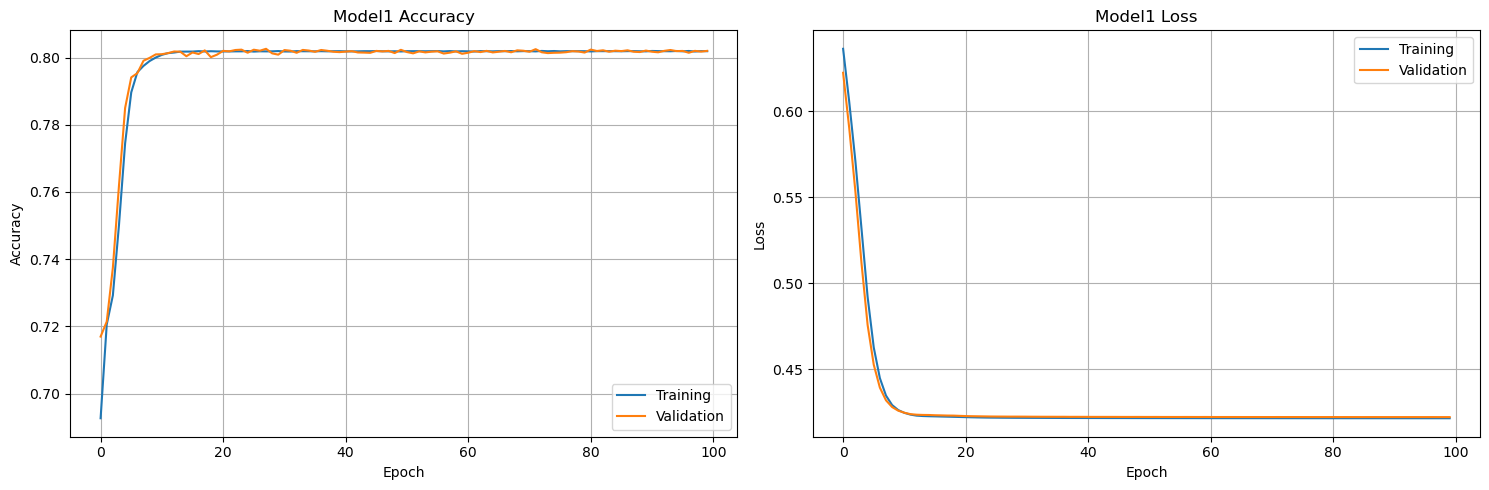

ROC curve plot saved to ./plots/Model1_roc_curve.png


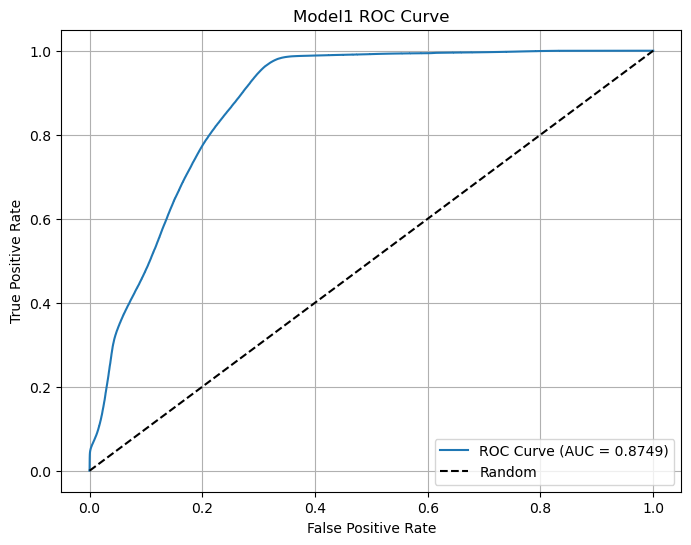

In [3]:
m1 = Model1()                 # your subclass

m1.loadTfRecords()            # <-- IMPORTANT: load training/validation generators

m1.makeUnquantizedModel()
m1.trainModel()
m1.evaluate()
m1.plotModel()

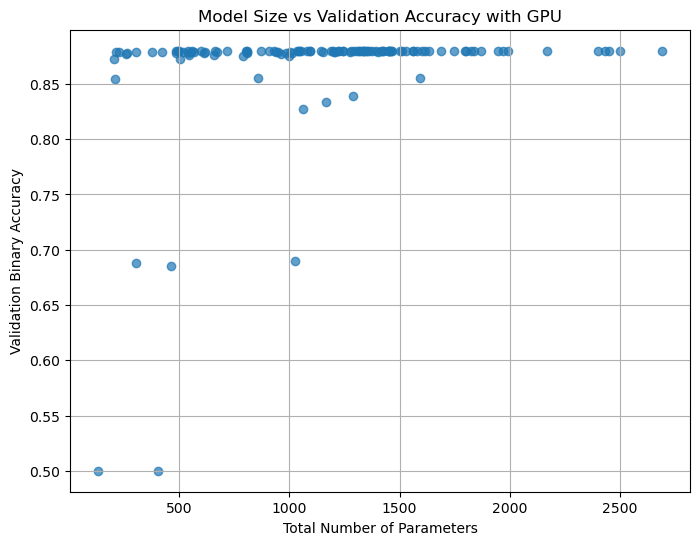

In [4]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


base_dir = "/home/ryanmichaud/common_repo/Muon_Collider_Smart_Pixels/ryan/hp_search_1_30"

results = []

# helper: builds a model with these layer widths and counts params
def count_params_from_widths(r1):
    input1 = tf.keras.layers.Input(shape=(1,))
    input2 = tf.keras.layers.Input(shape=(1,))
    input3 = tf.keras.layers.Input(shape=(1,))
    input4 = tf.keras.layers.Input(shape=(1,))
    inputs = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

    x = tf.keras.layers.Dense(r1, activation='relu')(inputs)
    x = tf.keras.layers.Dense(r2, activation='relu')(x)
    x = tf.keras.layers.Dense(r3, activation='relu')(x)
    x = tf.keras.layers.Dense(r4, activation='relu')(x)
    x = tf.keras.layers.Dense(r5, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model([input1,input2,input3,input4], out)
    return model.count_params()

# loop through all trial folders
for i in range(1, 120):
    trial_folder = os.path.join(base_dir, f"trial_{i:003d}")
    trial_json = os.path.join(trial_folder, "trial.json")

    if not os.path.exists(trial_json):
        continue

    with open(trial_json, "r") as f:
        data = json.load(f)

    hp_values = data["hyperparameters"]["values"]
    r1 = hp_values["1"]
    r2 = hp_values["2"]
    r3 = hp_values["3"]
    r4 = hp_values["4"]
    r5 = hp_values["5"]

    val_acc = data["metrics"]["metrics"]["val_binary_accuracy"]["observations"][0]["value"][0]

    # compute number of parameters
    total_params = count_params_from_widths(r1)

    results.append({
        "trial": i,
        "row1": r1,
        "row2": r2,
        "row3": r3,
        "row4": r4,
        "row5": r5,
        "params": total_params,
        "val_accuracy": val_acc
    })

df = pd.DataFrame(results)
"""
filtered = df[(df["val_accuracy"] > 0.87) & (df["params"] < 500)]
print(filtered)
"""

# --- PLOT PARAM COUNT VS ACCURACY ---
plt.figure(figsize=(8,6))
plt.scatter(df["params"], df["val_accuracy"], alpha=0.7)

plt.xlabel("Total Number of Parameters")
plt.ylabel("Validation Binary Accuracy")
plt.title("Model Size vs Validation Accuracy with GPU")
plt.grid(True)

plt.show()


In [1]:
 import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


BASE_ROOT = "/home/ryanmichaud/common_repo/Muon_Collider_Smart_Pixels/ryan"

results = []

def count_params_from_widthsr2(r1):
    input1 = tf.keras.layers.Input(shape=(1,))
    input2 = tf.keras.layers.Input(shape=(1,))
    input3 = tf.keras.layers.Input(shape=(1,))
    input4 = tf.keras.layers.Input(shape=(1,))
    inputs = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

    x = tf.keras.layers.Dense(r1, activation='relu')(inputs)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model([input1,input2,input3,input4], out)
    return model.count_params()

def count_params_from_widthsr3(r1):
    input1 = tf.keras.layers.Input(shape=(1,))
    input2 = tf.keras.layers.Input(shape=(1,))
    input3 = tf.keras.layers.Input(shape=(1,))
    input4 = tf.keras.layers.Input(shape=(1,))
    inputs = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

    x = tf.keras.layers.Dense(r1, activation='relu')(inputs)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model([input1,input2,input3,input4], out)
    return model.count_params()

def count_params_from_widthsr4(r1):
    input1 = tf.keras.layers.Input(shape=(1,))
    input2 = tf.keras.layers.Input(shape=(1,))
    input3 = tf.keras.layers.Input(shape=(1,))
    input4 = tf.keras.layers.Input(shape=(1,))
    inputs = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

    x = tf.keras.layers.Dense(r1, activation='relu')(inputs)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model([input1,input2,input3,input4], out)
    return model.count_params()

def count_params_from_widthsr5(r1):
    input1 = tf.keras.layers.Input(shape=(1,))
    input2 = tf.keras.layers.Input(shape=(1,))
    input3 = tf.keras.layers.Input(shape=(1,))
    input4 = tf.keras.layers.Input(shape=(1,))
    inputs = tf.keras.layers.Concatenate()([input1, input2, input3, input4])

    x = tf.keras.layers.Dense(r1, activation='relu')(inputs)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    x = tf.keras.layers.Dense(r1, activation='relu')(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model([input1,input2,input3,input4], out)
    return model.count_params()


# 🔁 LOOP OVER hp_search_1rows ... hp_search_5rows
for rows in range(2, 2):
    base_dir = os.path.join(BASE_ROOT, f"hp_search_{rows}rows")

    for i in range(0, 10):
        trial_folder = os.path.join(base_dir, f"trial_{i:003d}")
        trial_json = os.path.join(trial_folder, "trial.json")

        if not os.path.exists(trial_json):
            continue

        with open(trial_json, "r") as f:
            data = json.load(f)

        hp = data["hyperparameters"]["values"]
        r1 = r2 = r3 = r4 = r5 = hp["1"]

        val_acc = data["metrics"]["metrics"]["val_binary_accuracy"]["observations"][0]["value"][0]
        if rows == 2:
            params = count_params_from_widthsr2(r1)
        if rows == 3:
            params = count_params_from_widthsr3(r1)
        
        if rows == 4:
            params = count_params_from_widthsr4(r1)

        if rows == 5:
            params = count_params_from_widthsr5(r1)

        results.append({
            "rows": rows,
            "trial": i,
            "row1": r1,
            "params": params,
            "val_accuracy": val_acc
        })

df = pd.DataFrame(results)
print(df)


plt.figure(figsize=(8,6))
for rows in sorted(df["rows"].unique()):
    s = df[df["rows"] == rows]
    plt.scatter(s["params"], s["val_accuracy"], alpha=0.7, label=f"{rows} rows")

plt.xlabel("Total Number of Parameters")
plt.ylabel("Validation Binary Accuracy")
plt.title("Validation Accuracy vs Params")
plt.grid(True)
plt.legend()
plt.show()


2026-02-11 09:50:59.851055: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-11 09:50:59.892554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Empty DataFrame
Columns: []
Index: []


KeyError: 'rows'

<Figure size 800x600 with 0 Axes>

Found trial.json files: 10
Example: ['hyperparameter_tuning/hp_search_2rows_matching/trial_000/trial.json', 'hyperparameter_tuning/hp_search_2rows_matching/trial_001/trial.json', 'hyperparameter_tuning/hp_search_2rows_matching/trial_002/trial.json']
                                          trial_json  r1  params  val_accuracy
9  hyperparameter_tuning/hp_search_2rows_matching...  11     199      0.879435
3  hyperparameter_tuning/hp_search_2rows_matching...   8     121      0.877607
1  hyperparameter_tuning/hp_search_2rows_matching...   9     145      0.877287
0  hyperparameter_tuning/hp_search_2rows_matching...  10     171      0.877019
4  hyperparameter_tuning/hp_search_2rows_matching...   5      61      0.875847
5  hyperparameter_tuning/hp_search_2rows_matching...   7      99      0.875290
6  hyperparameter_tuning/hp_search_2rows_matching...   6      79      0.871832
7  hyperparameter_tuning/hp_search_2rows_matching...   3      31      0.871185
2  hyperparameter_tuning/hp_search_2row

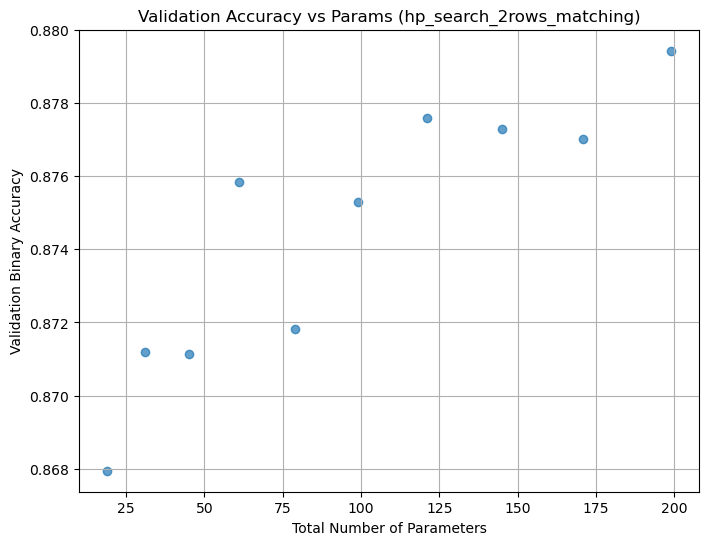

In [15]:
import os, glob, json
import pandas as pd
import matplotlib.pyplot as plt

BASE = "hyperparameter_tuning/hp_search_2rows_matching"

trial_jsons = sorted(glob.glob(os.path.join(BASE, "trial_*", "trial.json")))
print("Found trial.json files:", len(trial_jsons))
print("Example:", trial_jsons[:3])

rows = []
for tj in trial_jsons:
    with open(tj, "r") as f:
        data = json.load(f)

    hp = data["hyperparameters"]["values"]
    r1 = hp["1"]  # your width hyperparameter

    # Grab best/recorded val_binary_accuracy
    # (some versions store multiple observations; take max over all observed values)
    obs = data["metrics"]["metrics"]["val_binary_accuracy"]["observations"]
    vals = [o["value"][0] for o in obs if "value" in o and o["value"]]
    if not vals:
        continue
    val_acc = max(vals)

    # Params for: inputs=4 -> Dense(r1) -> Dense(r1) -> Dense(1)
    # Dense(a->b): a*b weights + b biases
    params = (4*r1 + r1) + (r1*r1 + r1) + (r1*1 + 1)

    rows.append({
        "trial_json": tj,
        "r1": r1,
        "params": params,
        "val_accuracy": val_acc
    })

df = pd.DataFrame(rows)
print(df.sort_values("val_accuracy", ascending=False).head(10))

plt.figure(figsize=(8,6))
plt.scatter(df["params"], df["val_accuracy"], alpha=0.7)
plt.xlabel("Total Number of Parameters")
plt.ylabel("Validation Binary Accuracy")
plt.title("Validation Accuracy vs Params (hp_search_2rows_matching)")
plt.grid(True)
plt.show()


In [8]:
import tensorflow as tf

m1 = Model1()
m1.loadTfRecords()

m1.models["Unquantized"] = tf.keras.models.load_model("Model1_best.h5", compile=True)

# if your evaluate() calls model.evaluate internally, make sure it’s compiled
m1.models["Unquantized"].compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["binary_accuracy"],
)

m1.evaluate()   # whatever your SmartPixModel.evaluate() does



Loading training data from: /local/d1/smartpixML/filtering_models/shuffling_data/all_batches_shuffled_bigData_try2/filtering_records16384_data_shuffled_single_bigData//tfrecords_train/
Loading validation data from: /local/d1/smartpixML/filtering_models/shuffling_data/all_batches_shuffled_bigData_try2/filtering_records16384_data_shuffled_single_bigData//tfrecords_validation/
Using batch_size=16384 to match TFRecord format


NameError: name 'ODG2' is not defined